In [56]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss
from scipy.ndimage import gaussian_filter1d
import pandas as pd

In [53]:
def get_local_minima_v3(scan_dist,scan_range =30,include_max = True,include_oor = True,safety_distance = 0):
    scan_dist[scan_dist>scan_range]=-1
    oor = np.where(scan_dist==-1)[0]
    
    max_dist = np.array([[],[]])
    loc_max_dist = np.array([[],[]])
    oor_dist = np.array([[],[]])
    
    if include_max:
        max_dist_idx = np.random.choice(np.where(scan_dist == np.max(scan_dist))[0])
        max_dist = np.max(scan_dist)-1 if np.max(scan_dist)>0 else scan_range-1
        max_dist = np.array([[max_dist_idx],[max_dist-safety_distance]]) 
        
        loc_max_idx = ss.argrelextrema(scan_dist, np.greater)[0]
        
        loc_max_dist = scan_dist[loc_max_idx]-safety_distance
        loc_max_dist[loc_max_dist<=0] = scan_range-1
        loc_max_dist = np.vstack([loc_max_idx,loc_max_dist]) 
    
    if oor.size!=0 and include_oor:

        indecies = np.where((oor[:-1]-oor[1:])!=-1)[0]
        if indecies.size!=0:
            slices=[]
            if (0 in oor) and (359 in oor): 
                #print('around 0')
                slices.append([oor[indecies[0]],oor[indecies[-1]+1]-360])
            else:
                slices.append([oor[0],oor[indecies[0]]])
                slices.append([oor[indecies[-1]+1],oor[-1]])

            for idx in range(indecies.size):

                if idx!=0:
                    slices.append([oor[indecies[idx-1]+1],oor[indecies[idx]]])
            
            slices = np.array(slices)
            
            oor_dist=np.mean(slices,axis=1).astype(np.int16)
        else:
            oor_dist = np.array([np.mean([oor[0],oor[-1]])])
        
        oor_dist = np.vstack((oor_dist,np.full((oor_dist.shape),(scan_range-1-safety_distance))))
        
    pos_angles = np.concatenate([oor_dist,max_dist,loc_max_dist],axis=1)
        
    return pos_angles

def vis_scan(position,distances,maze=None,mode='opencv'):
    '''Visualize distances from scan in original maze'''
    if mode == 'opencv':
        y,x=position
        cv2.circle(maze,(x,y),radius = 1,color = (0,0,255),thickness=-1)
        for angle,dist in enumerate(distances):
            if dist != -1:
                dx,dy = int(dist*np.cos(angle*np.pi/180)),int(dist*np.sin(angle*np.pi/180))
                sx,sy = x+dx,y+dy
                cv2.circle(maze,(sx,sy),radius = 1,color = (int((255-(angle/360)*255)),0,int((angle/360)*255)),thickness=-1)
        
    elif mode == 'plt':
        x,y=position
        scan_points = []
        for angle,dist in enumerate(distances):
            if dist != -1:
                dx,dy = dist*np.cos(angle*np.pi/180),dist*np.sin(angle*np.pi/180)
                sx,sy = x+dx,y+dy

                scan_points.append([sx,sy,angle])
        scan_points=np.array(scan_points)
        return scan_points
       

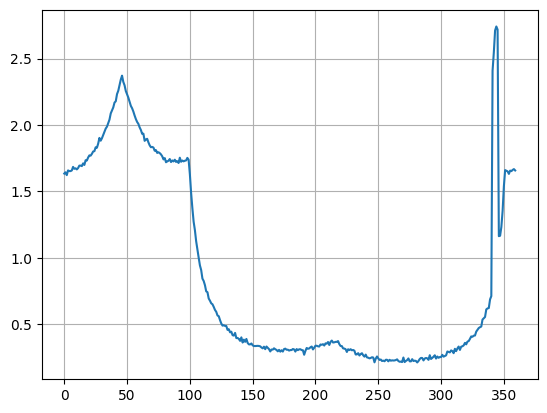

In [88]:
dist = np.loadtxt('lidar_values.txt')
plt.plot(np.arange(0,360,1),dist)
plt.grid()

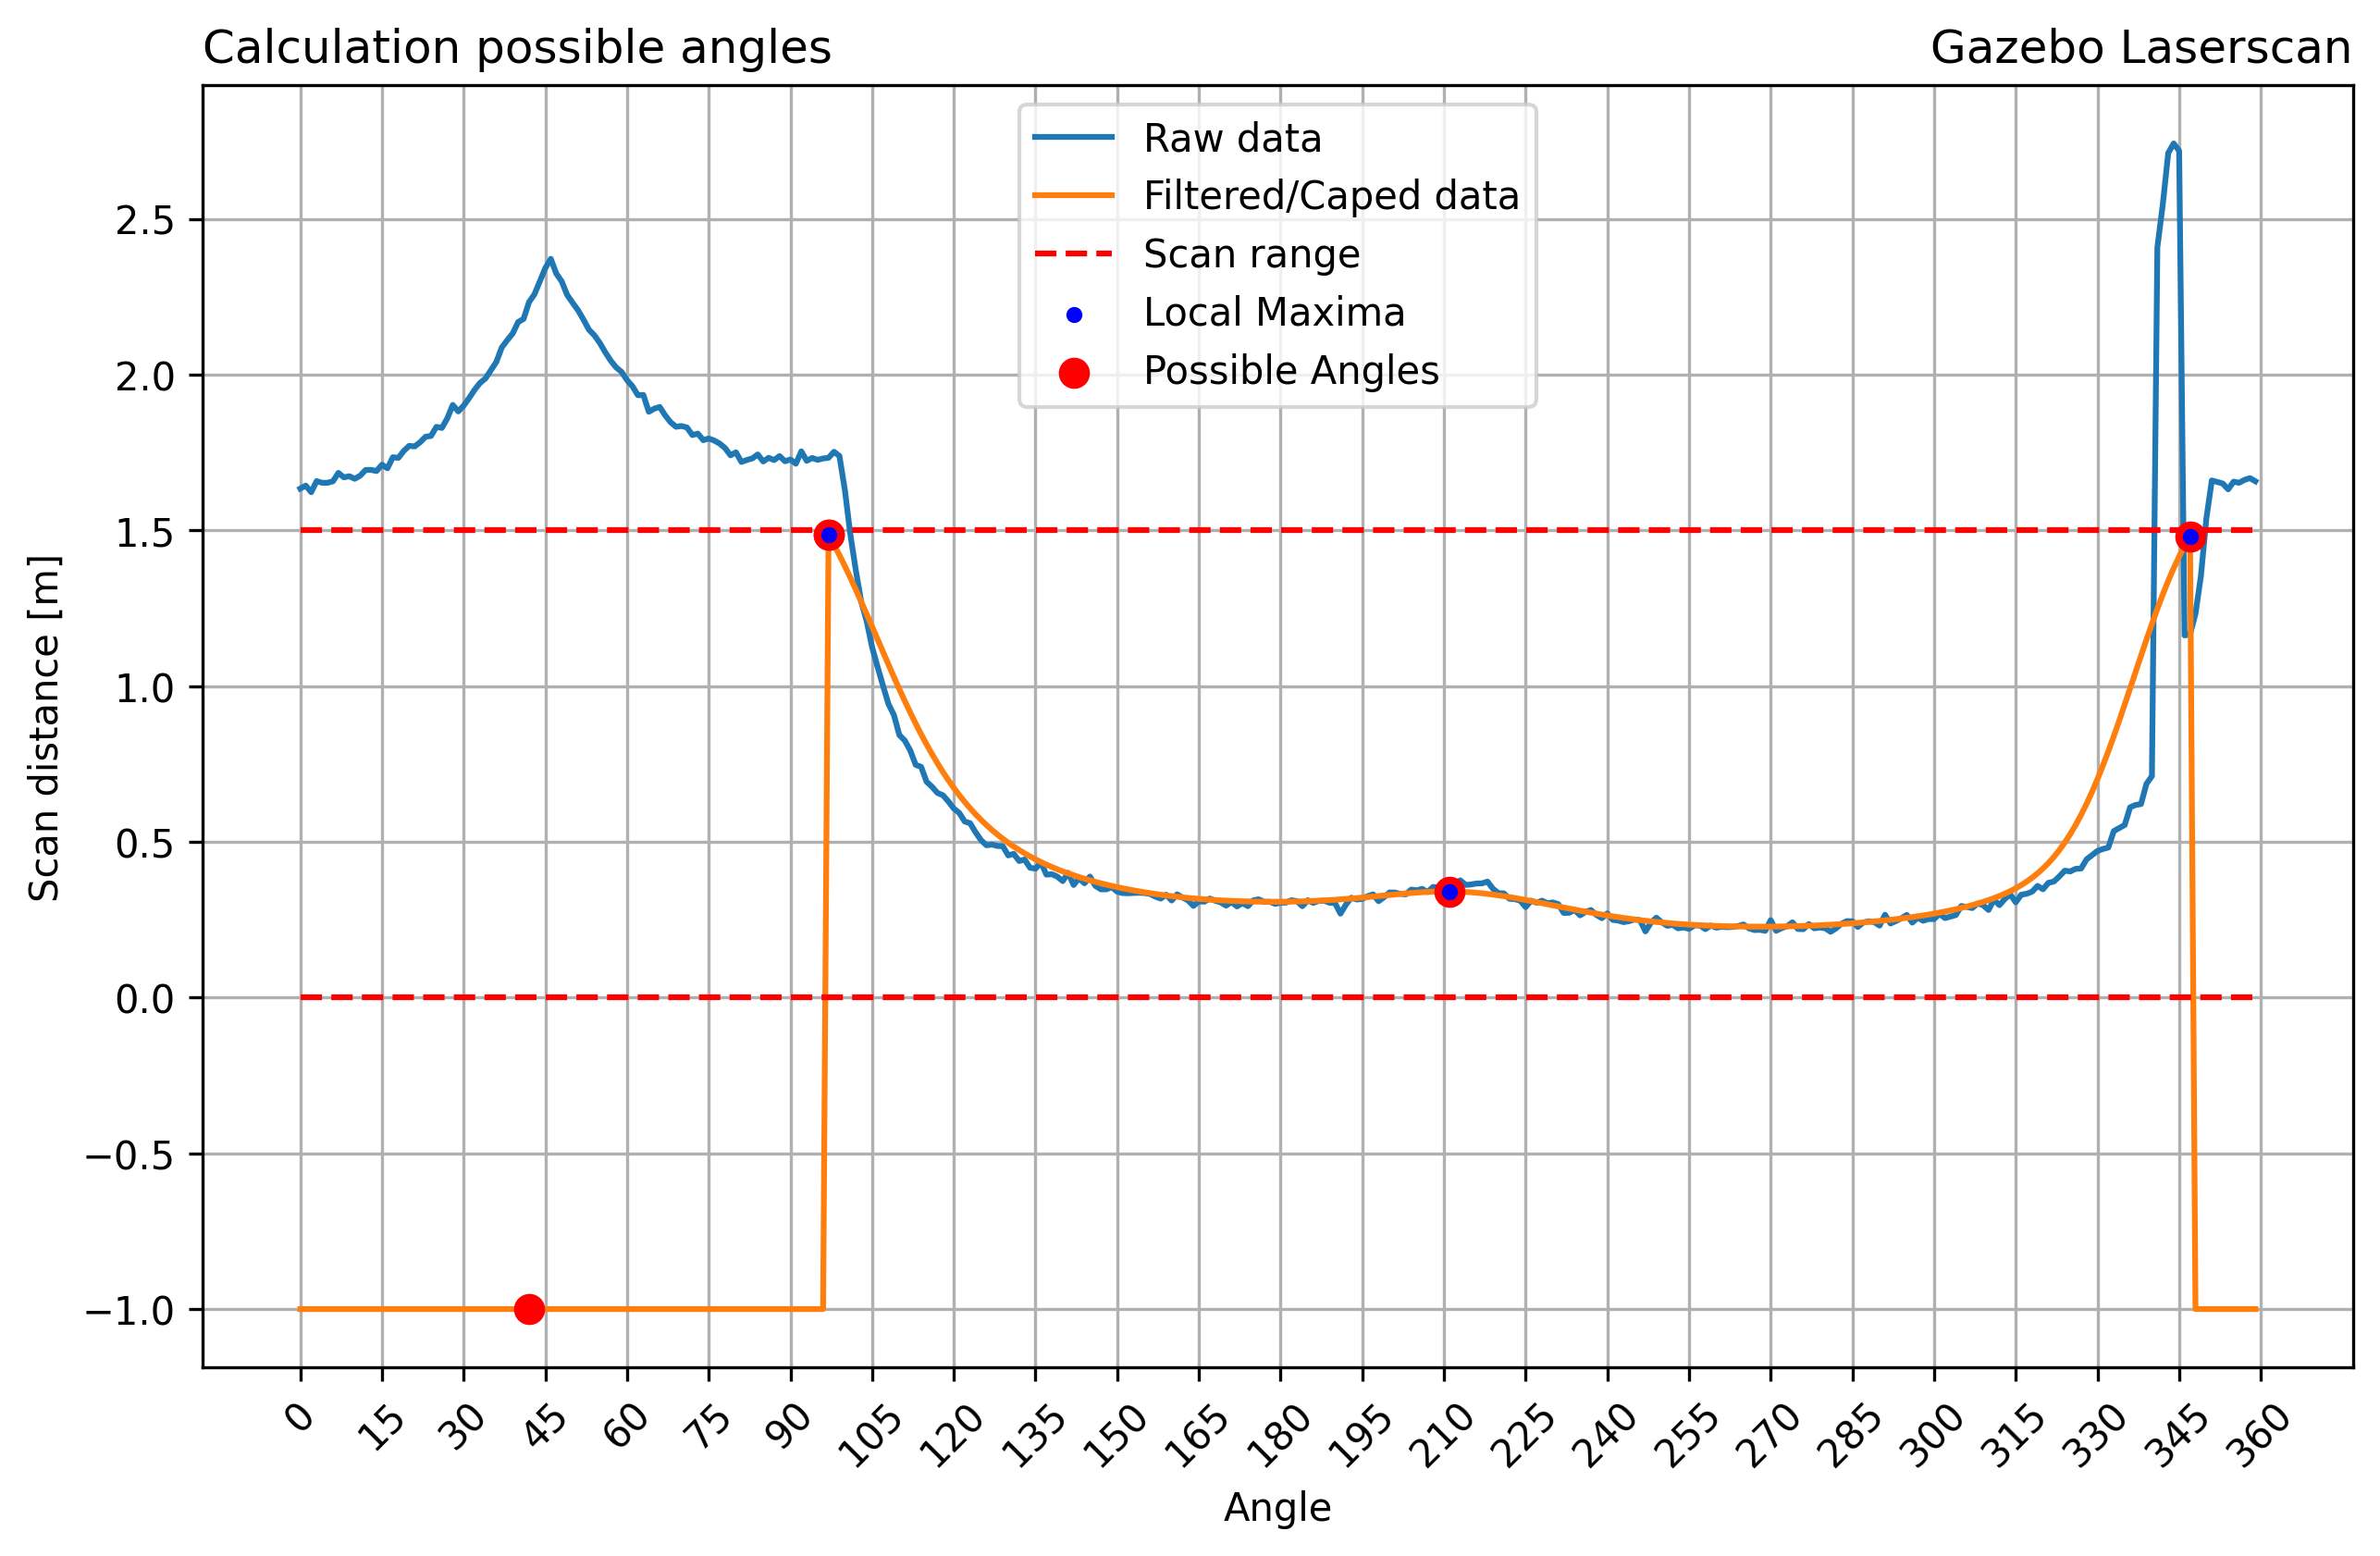

[[4.20000000e+01 9.70000000e+01 9.70000000e+01 2.11000000e+02
  3.47000000e+02]
 [5.00000000e-01 4.85497310e-01 1.48549731e+00 3.40693091e-01
  1.48075684e+00]]
(244, 3)


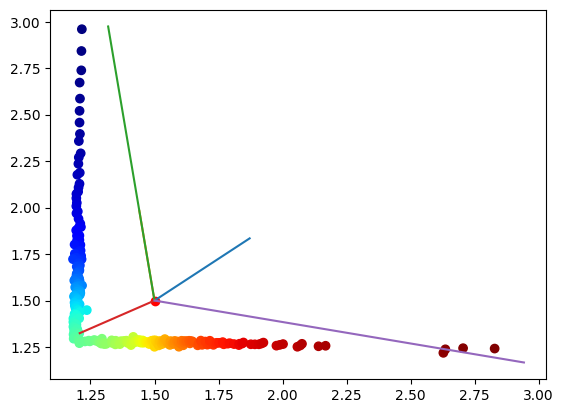

In [135]:
dist = np.loadtxt('lidar_values.txt')
scan_range=1.5 # Maximum scan range
sigma= 10 # Smoothing of sensor signal

map_position=[scan_range,scan_range]#current location

#Visualization of in range scan values
adj_scan = np.copy(dist)
adj_scan[adj_scan>scan_range]=-1 # Thresholding of scan values


# Filtering for calculation of local Maxima/possible angles
adj_dist = np.copy(dist)
adj_dist = gaussian_filter1d(adj_dist, sigma)
adj_dist[adj_dist>1.5]=-1

actions = get_local_minima_v3(adj_dist,scan_range=1.5)


loc_max_idx = ss.argrelextrema(adj_dist, np.greater)[0]
plt.figure(figsize=(10,6),dpi=300,facecolor='w')
plt.plot(np.arange(0,360,1),dist,label='Raw data')
plt.plot(np.arange(0,360,1),adj_dist,label='Filtered/Caped data')
plt.plot(np.arange(0,360,1),scan_range*np.ones(360,),ls='--',c='r',label='Scan range')
plt.plot(np.arange(0,360,1),np.zeros(360,),ls='--',c='r')

plt.scatter(loc_max_idx,adj_dist[loc_max_idx],c='b',s=10,zorder = 10,label='Local Maxima')
plt.scatter(actions[0,:],adj_dist[actions[0,:].astype(np.int64)],c='r',s=50,zorder = 9,label='Possible Angles')

plt.xticks(np.arange(0,375,15),rotation=45)
plt.xlabel('Angle')
plt.ylabel('Scan distance [m]')
plt.grid()
plt.title('Calculation possible angles',loc='left')
plt.title('Gazebo Laserscan',loc='right')
plt.legend(loc='upper center')
plt.show()


print(actions)



for idx in range(actions.shape[1]):
    ang,d = actions[:,idx]
    dx,dy = (d)*np.cos(ang*np.pi/180),(d)*np.sin(ang*np.pi/180)
    sx,sy = map_position[0]+dx,map_position[1]+dy
    
    plt.plot([scan_range,sx],[scan_range,sy],label = f'Angle {idx}: {ang}')
    
scan_points = vis_scan((scan_range,scan_range),adj_scan,mode='plt')
print(scan_points.shape)
plt.scatter([scan_range],[scan_range],c='r',label = 'Robot Position')
plt.scatter(scan_points[:,0],scan_points[:,1],c=scan_points[:,2],cmap='jet',label = 'Simulated Laserscan')

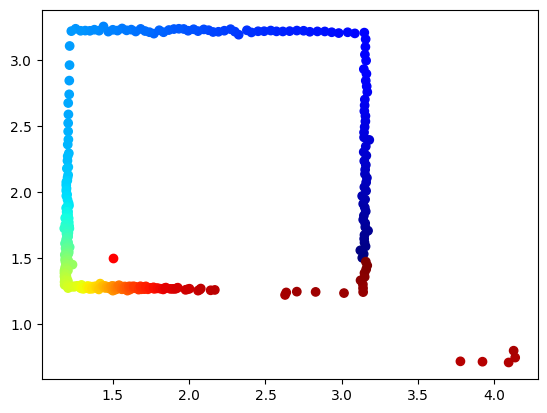

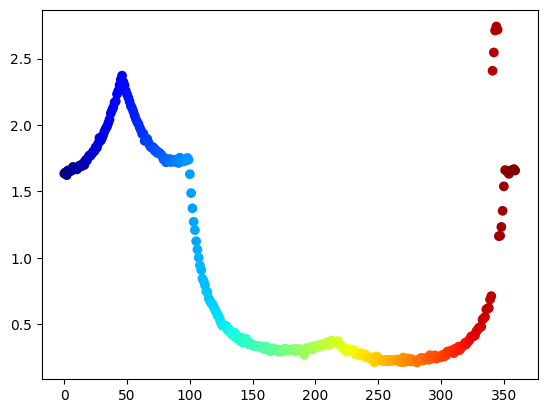

In [109]:
scan_range=1.5
scan_points = vis_scan((scan_range,scan_range),dist,mode='plt')
plt.scatter([scan_range],[scan_range],c='r',label = 'Robot Position')
plt.scatter(scan_points[:,0],scan_points[:,1],c=scan_points[:,2],cmap='jet',label = 'Simulated Laserscan')
plt.show()
plt.scatter(np.arange(0,360,1),dist,c=np.arange(0,360,1),cmap='jet')